In [51]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")


%cd './drive/My Drive/Projekt/FashionMnist'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/My Drive/Projekt/FashionMnist'
/content/drive/My Drive/Projekt/FashionMnist


Probowałem odtworzyć drugi z modeli z tabelki w repo FashionMnist (ten z Tensorflow doc).

Architektura sieci wygląda tak samo jak tam. Nie jestem pewien co do optymalizatora, ale są na pewno bardzo podobne.

In [52]:
#Importy i sprawdzenie czy mamy CUDA
import torch
import torchvision

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
dev

'cuda:0'

In [53]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

#katalog, w którym przechowujemy dane
root = "data"
batch_size = 200

#transformacje wektorów wejściowych
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

train_dataset = dsets.FashionMNIST(root=root,
                            train=True,
                            transform=transform,
                            download=True)

test_dataset = dsets.FashionMNIST(root=root,
                            train=False,
                            transform=transform)

trainloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=True) 

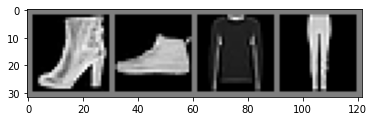

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))

In [55]:
import torch.nn as nn
import torch.nn.functional as F


#architektura sieci
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.fc2 = nn.Linear(1024, 130)
        self.drop = nn.Dropout(0.4) #prawdopodobieństwo 0.6 że element zostaje

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


net = Net()


In [56]:
#jeżeli można, używamy CUDA
if torch.cuda.is_available():
  net.to("cuda:0")

In [57]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1,
                              patience=0, verbose=True)

In [58]:
def accuracy(model, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if torch.cuda.is_available():
            images = images.to("cuda:0")
            labels = labels.to("cuda:0")

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [59]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
          inputs = inputs.to("cuda:0")
          labels = labels.to("cuda:0")


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_accuracy = accuracy(net, trainloader)
    print('%d loss: %.3f train accuracy: %.2f %%' %
          (epoch + 1, 
            running_loss / 200, 
            epoch_accuracy))
    running_loss = 0.0
    scheduler.step(epoch_accuracy)

print('Finished Training')


1 loss: 1.479 train accuracy: 83.48 %
2 loss: 0.631 train accuracy: 86.62 %
3 loss: 0.534 train accuracy: 87.76 %
4 loss: 0.479 train accuracy: 89.23 %
5 loss: 0.437 train accuracy: 90.10 %
6 loss: 0.405 train accuracy: 90.40 %
7 loss: 0.381 train accuracy: 91.25 %
8 loss: 0.363 train accuracy: 91.63 %
9 loss: 0.343 train accuracy: 92.40 %
10 loss: 0.327 train accuracy: 92.76 %
11 loss: 0.314 train accuracy: 92.73 %
Epoch    11: reducing learning rate of group 0 to 1.0000e-03.
12 loss: 0.275 train accuracy: 93.53 %
13 loss: 0.264 train accuracy: 93.75 %
14 loss: 0.260 train accuracy: 93.78 %
15 loss: 0.259 train accuracy: 93.88 %
16 loss: 0.256 train accuracy: 93.98 %
17 loss: 0.253 train accuracy: 94.04 %
18 loss: 0.251 train accuracy: 94.14 %
19 loss: 0.250 train accuracy: 94.10 %
Epoch    19: reducing learning rate of group 0 to 1.0000e-04.
20 loss: 0.244 train accuracy: 94.23 %
21 loss: 0.243 train accuracy: 94.11 %
Epoch    21: reducing learning rate of group 0 to 1.0000e-05.
22 l

In [60]:
print('Accuracy of the network on test images: %.2f %%' % (
    accuracy(net, testloader)))

Accuracy of the network on test images: 91.45 %
